In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    # tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


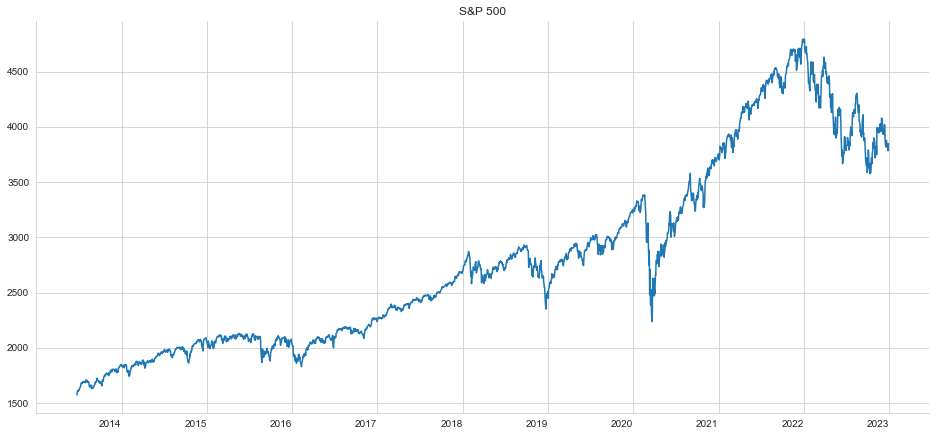

In [3]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2023').dropna()
ax = sp500.plot(title='S&P 500', legend=False, figsize=(16, 8), rot=0)
ax.set_xlabel('')
sns.despine()

In [4]:
# Preprocessing
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), index=sp500.index)
sp500_scaled.describe()

count    2399.000000
mean        0.381012
std         0.264470
min         0.000000
25%         0.157045
50%         0.335573
75%         0.549186
max         1.000000
dtype: float64

In [5]:
# Generating recurrent sequences from our time series
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 63
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-09-23,0.000000,0.004635,0.009359,0.012443,0.010296,0.012989,0.012716,0.013129,0.018241,0.020900,...,0.030594,0.034404,0.035998,0.034227,0.035645,0.038626,0.040847,0.047288,0.046301,0.042445
2013-09-24,0.004635,0.009359,0.012443,0.010296,0.012989,0.012716,0.013129,0.018241,0.020900,0.024579,...,0.034404,0.035998,0.034227,0.035645,0.038626,0.040847,0.047288,0.046301,0.042445,0.039941
2013-09-25,0.009359,0.012443,0.010296,0.012989,0.012716,0.013129,0.018241,0.020900,0.024579,0.024672,...,0.035998,0.034227,0.035645,0.038626,0.040847,0.047288,0.046301,0.042445,0.039941,0.038570
2013-09-26,0.012443,0.010296,0.012989,0.012716,0.013129,0.018241,0.020900,0.024579,0.024672,0.031621,...,0.034227,0.035645,0.038626,0.040847,0.047288,0.046301,0.042445,0.039941,0.038570,0.037128
2013-09-27,0.010296,0.012989,0.012716,0.013129,0.018241,0.020900,0.024579,0.024672,0.031621,0.033225,...,0.035645,0.038626,0.040847,0.047288,0.046301,0.042445,0.039941,0.038570,0.037128,0.038958


In [6]:
y.head()

DATE
2013-09-23    0.039941
2013-09-24    0.038570
2013-09-25    0.037128
2013-09-26    0.038958
2013-09-27    0.036811
dtype: float64

In [7]:
X.shape

(2336, 63)

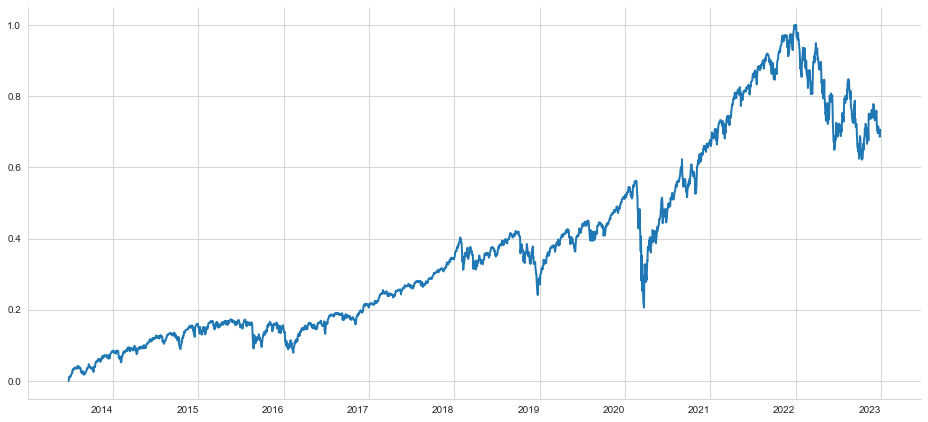

In [8]:
# Train-test split
ax = sp500_scaled.plot(lw=2, figsize=(16, 8), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
X_train = X[:'2021'].values.reshape(-1, window_size, 1)
y_train = y[:'2021']

# keep the last year for testing
X_test = X['2022'].values.reshape(-1, window_size, 1)
y_test = y['2022']
n_obs, window_size, n_features = X_train.shape
y_train.shape

(2085,)

In [10]:
# Keras LSTM Layer
rnn = Sequential([LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'), Dense(1, name='Output')
])

In [11]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the Model
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True,
                        validation_data=(X_test, y_test), callbacks=[early_stopping, checkpointer],
                        verbose=1, workers=6)

Epoch 1/150
105/105 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00001: val_loss improved from inf to 0.00179, saving model to results/univariate_time_series\rnn.h5
105/105 [==============================] - 5s 10ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 2/150
 98/105 [===========================>..] - ETA: 0s - loss: 5.1920e-04
Epoch 00002: val_loss improved from 0.00179 to 0.00165, saving model to results/univariate_time_series\rnn.h5
105/105 [==============================] - 1s 6ms/step - loss: 5.2240e-04 - val_loss: 0.0016
Epoch 3/150
101/105 [===========================>..] - ETA: 0s - loss: 4.2005e-04
Epoch 00003: val_loss improved from 0.00165 to 0.00135, saving model to results/univariate_time_series\rnn.h5
105/105 [==============================] - 1s 6ms/step - loss: 4.2035e-04 - val_loss: 0.0013
Epoch 4/150
102/105 [============================>.] - ETA: 0s - loss: 3.9075e-04
Epoch 00004: val_loss did not improve from 0.00135
105/105 [==============

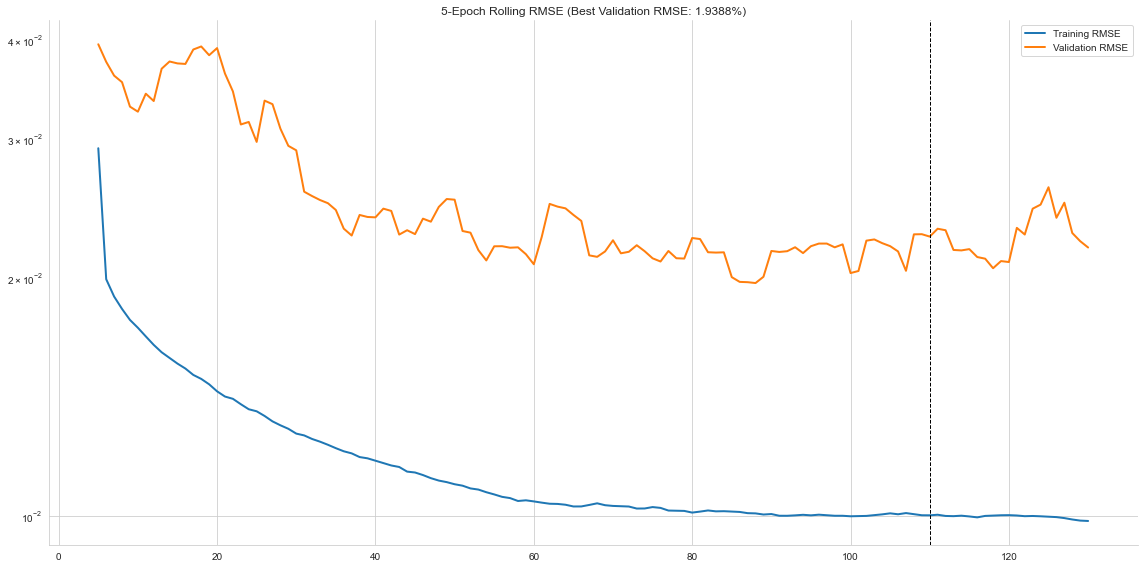

In [13]:
# Evaluate model performance
fig, ax = plt.subplots(figsize=(16, 8))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [14]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0092 | Test RMSE: 0.0194


In [15]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9984 | Test IC: 0.9721


In [16]:
# Rescale predictions
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(),index=y_test.index))
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 29.61 | Test RMSE: 62.50'

In [17]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

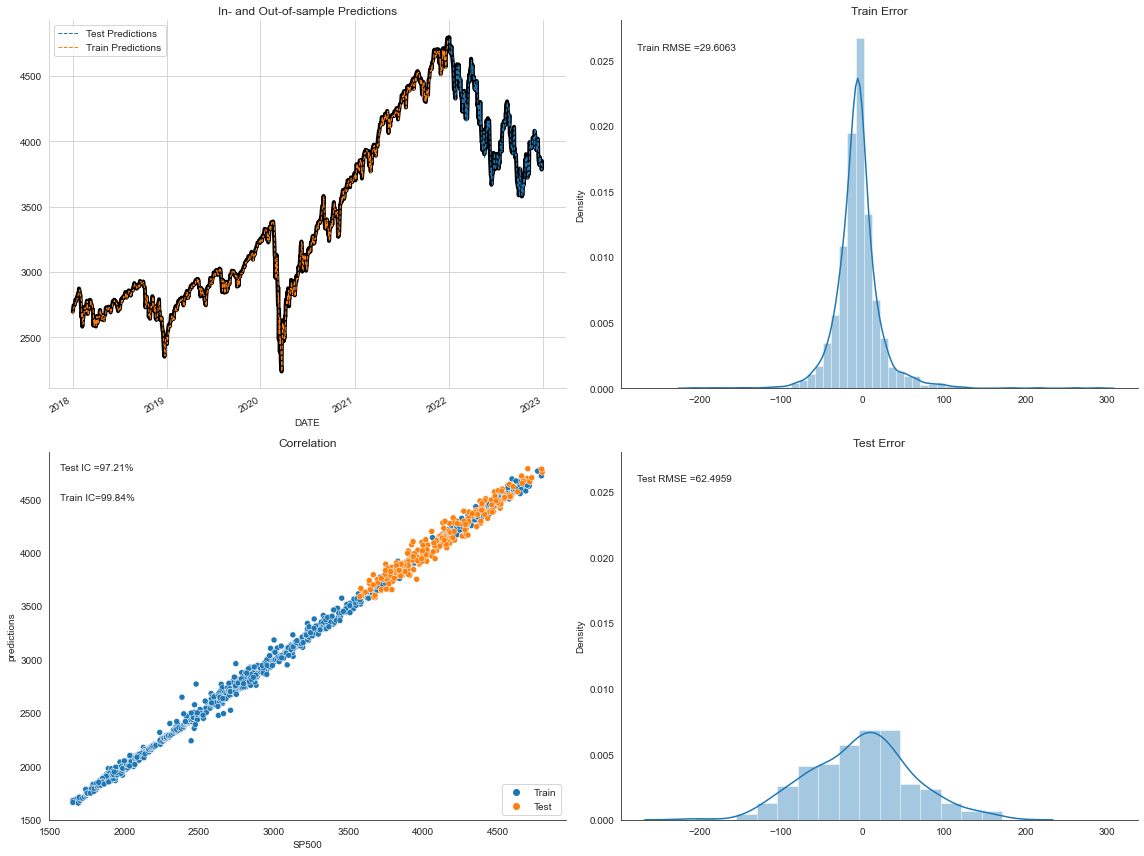

In [18]:
# Plot Results
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)

sp500.loc['2018':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2018':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);